In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
#nltk.download('punkt')
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from gensim.models import CoherenceModel
#from pyLDAvis import gensim


Using TensorFlow backend.


In [2]:
tweets = pd.read_csv("dataset/Tweets.csv")

In [4]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,NaN,Pacific Time (US & Canada)


In [4]:
tweets.airline_sentiment.value_counts()/len(tweets)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

# Positive vs Negative Sentiment Categories Using LDA

In [4]:
pos = tweets[tweets.airline_sentiment == 'positive']
neg = tweets[tweets.airline_sentiment == 'negative']
neu = tweets[tweets.airline_sentiment == 'neutral']

In [5]:
neg = neg.reset_index(drop=True)

### negative tweets categories - overall

In [34]:
text = neg.text.dropna()
text = text.to_string().lower()
print("There are {} wor ds in the combination of all review.".format(len(text)))

There are 532323 wor ds in the combination of all review.


# LDA Model to Find Topics for Negative Reviews

In [8]:
#getting the adjectives and conjuction using spacy
doc = []
t = []
for row in range(len(neg.text)):
    doc.append(nlp(neg.text[row]))
    t.append([str(token) for token in doc[row] if (token.pos_ in ["ADJ","CCONJ"])])

In [160]:
ts = set()
for i in range(len(t)):
    ts.add(i)

In [8]:
#preprocess data
def preprocess(text):
    stopwords = set(STOPWORDS)
    stopwords.update(["american", "air","airline","thank","united","us","airways","virgin","america","jetblue","youre","extremely",
                     "usairway","usairways","flight","americanair","southwestair","southwestairlines","arbitrarily","dream","crazy",
                     "southwestairway","southwestairways","virginamerica","really","will","going","thanks","thankyou","passengersdont",
                     "please","got","let","take","help","already","never","now","told","guy","new","sure","still","amp","continue",
                     "plane","tell","ye","trying","yes","guy","much","appreciate", "thx","back","ok","good","credit","aacom",
                     "flying","love","great","awesome","see","nice","alway","httptcojwl26g6lrw","dontflythem","motherinlaw","night",
                     "nogearnotraining","seriously","didnt","coudnt","cant","wont","dont","wat","buffaloniagara","hasshe","morning",
                     "woulda","people","try","youve","youd","yours","flightled","tomorrow","today","wat","jfkyou","flite","cause",
                     "flightr","flight","need","hours","nooooo","like","doesnt","right","talk","tweet","mention","pbijfk","ridiculuous",
                     "wasnt","suppose","want","understand","come","work","worse","treat","think","know","worst","paulo","staduim",
                     "wouldnt","stay","away","wont","werent","happen","sorry","havent","tonight","drive","life","thing","aa951",
                     "whats","theyre","better","thats","allow","hope","stop","cool","niece","happy","word","customercant",
                     "suck","sunday","monday","tuesday","wednesday","thursday","friday","saturday","weekend","ruin","shouldnt",
                     "miami","los angeles","new york","chicago","dallas","apparently","itover","someones","savannah","lucymay",
                     "betterother","instead","look","hopefully","yesterday","antonio","unacceptable","folks","record",'arent',
                     "miss","hang","wrong","stick","grind","tarmac","theres","forget","terrible","clothe","terrible","break",
                     "actually","frustrate","correct","ridiculous","expect","different","pathetic","bother","follow","fault",
                     "impossible","point","cover","person","ask","speak","things","earlier","mean","select","minutes",
                     "unite","horrible","country","leave","speak","apologize","faster","hop","confuse","lose","flightd","hear",
                     "literally","years","surprise","bump","fail","compensate","hand","helpful","upset","friend","excuse","claim",
                     "situation","multiple","weather","choose","company","believe","question","kick","anymore","awful","delta",
                      "dozen","medical","completely","finally", "waste","shock","annoy","maybe","strand","mess","finally",
                      "plan","place","apology","center","plan","twitter","promise","prefer","count","maybe","shock","longer","meet",
                         "important","drop"])
 
    #stopwords.update([i for i in ts])
    # stopwords.update([str(i).lower() for i in cities.City]) #removing City names in US
    r = re.compile(r'(?<=\@)(\w+)') #remove words after tags --> usually twitter account
    ra = re.compile(r'(?<=\#)(\w+)') #remove words after hashtags
    ro = re.compile(r'(flt\d*)') #remove words after flight number
    names = r.findall(text.lower())
    hashtag = ra.findall(text.lower())
    flight = ro.findall(text.lower())
    lmtzr = WordNetLemmatizer()
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lmtzr.lemmatize(item,'v'))
        return lemmatized
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    #doc = nlp(text)
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    tokens = [ch for ch in tokens if len(ch)>4] #remove words with character length below 2
    tokens = [ch for ch in tokens if len(ch)<=15] #remove words with character length above 15 
    lemm = stem_tokens(tokens, lmtzr)
    lemstop = [i for i in lemm if i not in stopwords]
    lemstopcl = [i for i in lemstop if i not in names]
    lemstopcl = [i for i in lemstopcl if i not in hashtag]
    lemstopcl = [i for i in lemstopcl if i not in flight]
    lemstopcl = [i for i in lemstopcl if not i.isdigit()]
    #lemstopcl1 = [i for i in lemstopcl if i not in t]
    return lemstopcl


In [178]:
#testing the tokenizer
text = """@Jenny @Joe and @Susan we are all very dissapointing in your service with the LONG delays
            for flt15539 560948 #notdoingthisanymore #dontflythem in New York to Chicago"""
preprocess(text)

['dissapointing', 'service', 'delay']

In [179]:
%%time
import warnings
warnings.simplefilter('ignore')

neg['token']=neg.text.map(preprocess)

CPU times: user 4.61 s, sys: 167 ms, total: 4.77 s
Wall time: 4.89 s


In [180]:
processed_docs=neg['token']
id2word = gensim.corpora.Dictionary(processed_docs)
corpus = [id2word.doc2bow(text) for text in processed_docs]


In [129]:
def compute_coherence_values(dictionary, corpus, texts, start, stop):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics,
                                                id2word=id2word,
                                               random_state=123,
                                               alpha='auto',
                                                eta='auto',
                                               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [130]:
start=3
stop=9
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=processed_docs,
                                                        start=start, 
                                                        stop=stop)

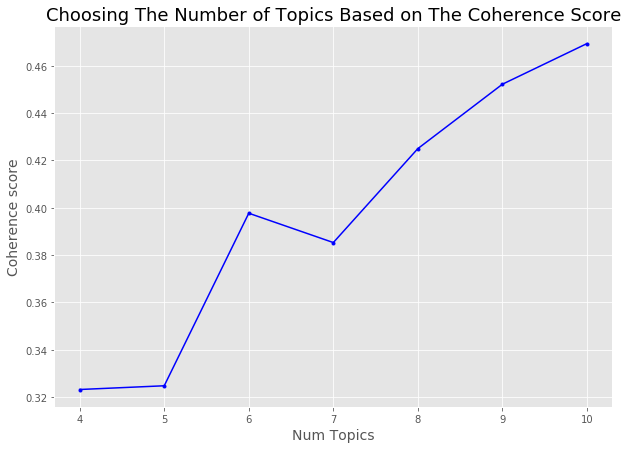

In [131]:
x = range(start, stop)
plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.plot(x, coherence_values, color = "blue",marker=".")
plt.xlabel("Num Topics", size=14)
plt.ylabel("Coherence score", size=14)
plt.title('Choosing The Number of Topics Based on The Coherence Score',size=18)
plt.show()

### Choosing 8 as the number of topics for negative reviews

In [182]:
%%time
# Create Dictionary
id2word = gensim.corpora.Dictionary(processed_docs)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_docs]

# Build LDA model
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           iterations=125,
                                           per_word_topics=True)
doc_lda = lda_model1[corpus]

CPU times: user 1min 28s, sys: 886 ms, total: 1min 29s
Wall time: 1min 31s


In [183]:
from pprint import pprint
pprint(lda_model4.print_topics())

[(0,
  '0.086*"service" + 0.064*"customer" + 0.062*"delay" + 0.049*"ticket" + '
  '0.041*"rebooked" + 0.035*"agents" + 0.028*"email" + 0.026*"response" + '
  '0.019*"passengers" + 0.019*"reason"'),
 (1,
  '0.130*"wait" + 0.109*"airport" + 0.055*"baggage" + 0.050*"sit" + '
  '0.028*"passenger" + 0.020*"receive" + 0.019*"information" + 0.019*"load" + '
  '0.018*"depart" + 0.012*"counter"'),
 (2,
  '0.301*"cancel" + 0.033*"staff" + 0.024*"fly" + 0.022*"assistance" + '
  '0.021*"reschedule" + 0.021*"hotel" + 0.020*"refund" + 0.015*"offer" + '
  '0.014*"money" + 0.012*"airports"'),
 (3,
  '0.195*"phone" + 0.083*"change" + 0.066*"online" + 0.057*"book" + '
  '0.035*"problems" + 0.020*"handle" + 0.019*"option" + 0.016*"contact" + '
  '0.015*"attempt" + 0.011*"ignore"'),
 (4,
  '0.160*"answer" + 0.146*"number" + 0.097*"reservation" + 0.031*"direct" + '
  '0.008*"fix" + 0.008*"flyer" + 0.006*"catch" + 0.005*"friends" + '
  '0.004*"head" + 0.001*"neglect"'),
 (5,
  '0.109*"time" + 0.078*"rebook"

In [184]:
# Compute Perplexity
print('\nPerplexity: ', lda_model4.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model4, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.346459933442205

Coherence Score:  0.6030993107622276


In [36]:
unseen_document = '''United has the WORST customer experience ever! first the website was down, then the boarding and checkin processes w so complicated and slow
                    '''
bow_vector = id2word.doc2bow(preprocess(unseen_document))
result = lda_model4.get_document_topics(bow_vector)
resultdict = dict(result)


orddict = sorted(resultdict, key=resultdict.get, reverse=True)
Keymax = 1
if resultdict[orddict[0]]-resultdict[orddict[1]] <=.08:
    Keymax +=orddict[1]
    print("Predicted topic: ",orddict[1]+1)
    print("Probability Score: ",resultdict[orddict[1]])
else:
    Keymax +=orddict[0]
    print("Predicted topic: ",orddict[0]+1)
    print("Probability Score: ",resultdict[orddict[0]])

#Keymax = max(resultdict, key=resultdict.get)+1
#print("Predicted Topic :", Keymax) 


if Keymax == 1:
    print('Delay and Customer Service')
elif Keymax == 2:
    print('Baggage Issue')
elif Keymax == 3:
    print('Reschedule and Refund')
elif Keymax == 4:
    print('Phone and Online Booking')
elif Keymax == 5:
    print('Reservation Issue')
elif Keymax == 6:
    print('Seating Preferences')
elif Keymax == 7:
    print('Extra Charges')
else:
    print('Customer Experience')
print("\n")

for index, score in resultdict.items():
    print("Score: {}\n Topic: {}\n Keywords:{} \n".format(score, index+1, lda_model4.print_topic(index)))

Predicted topic:  8
Probability Score:  0.24903516
Customer Experience


Score: 0.2876979112625122
 Topic: 1
 Keywords:0.086*"service" + 0.064*"customer" + 0.062*"delay" + 0.049*"ticket" + 0.041*"rebooked" + 0.035*"agents" + 0.028*"email" + 0.026*"response" + 0.019*"passengers" + 0.019*"reason" 

Score: 0.1020858883857727
 Topic: 2
 Keywords:0.130*"wait" + 0.109*"airport" + 0.055*"baggage" + 0.050*"sit" + 0.028*"passenger" + 0.020*"receive" + 0.019*"information" + 0.019*"load" + 0.018*"depart" + 0.012*"counter" 

Score: 0.15522658824920654
 Topic: 3
 Keywords:0.301*"cancel" + 0.033*"staff" + 0.024*"fly" + 0.022*"assistance" + 0.021*"reschedule" + 0.021*"hotel" + 0.020*"refund" + 0.015*"offer" + 0.014*"money" + 0.012*"airports" 

Score: 0.10287594795227051
 Topic: 4
 Keywords:0.195*"phone" + 0.083*"change" + 0.066*"online" + 0.057*"book" + 0.035*"problems" + 0.020*"handle" + 0.019*"option" + 0.016*"contact" + 0.015*"attempt" + 0.011*"ignore" 

Score: 0.035585545003414154
 Topic: 5
 Keyw

# Negative Sentiment Topics

In [189]:
lcorp =[]
for i in range(len(corpus)):
    lcorp.append(lda_model4.get_document_topics(corpus[i]))

In [190]:
topicscore = []
for i in range(len(lcorp)):
    topicscore.append(max(lcorp[i], key=lambda x: x[1]))

In [1]:
neg['topic_no']=[i[0]+1 for i in topicscore]
neg['topic_prob']=[i[1] for i in topicscore]
keywords=[]
for row in range(0,7):
    keywords.append([i[0] for i in lda_model4.show_topic(row)])
    
kywrd = []
kywrd.append([" , ".join(keywords[0])])
kywrd.append([" , ".join(keywords[1])])
kywrd.append([" , ".join(keywords[2])])
kywrd.append([" , ".join(keywords[3])])
kywrd.append([" , ".join(keywords[4])])
kywrd.append([" , ".join(keywords[5])])
kywrd.append([" , ".join(keywords[6])])

# Negative Topic Categorization
- Topic 1 --> Delay and Customer Service
- Topic 2 --> Baggage Issue
- Topic 3 --> Reschedule and Refund
- Topic 4 --> Phone and Online Booking
- Topic 5 --> Reservation Issue
- Topic 6 --> Seating Preferences
- Topic 7 --> Extra Charges
- Topic 8 --> Customer Experience

In [193]:
negf=neg
negf['keywords']=[kywrd[i-1] for i in negf.topic_no]

topic_desc = []
for i in negf.topic_no:
    if i == 1:
        topic_desc.append('Delay and Customer Service')
    elif i == 2:
        topic_desc.append('Baggage Issue')
    elif i == 3:
        topic_desc.append('Reschedule and Refund')
    elif i == 4:
        topic_desc.append('Phone and Online Booking')
    elif i == 5:
        topic_desc.append('Reservation Issue')
    elif i == 6:
        topic_desc.append('Seating Preferences')
    elif i == 7:
        topic_desc.append('Extra Charges')
    else:
        topic_desc.append('Customer Experience')
        
negf['topic_desc']=topic_desc

In [ ]:
negf.to_csv("dataset/labelled_airline_tweet.csv")